In [7]:
#we made our first submission to Kaggle, getting an accuracy score of 75.6%. While this is a good
#start, there is definitely room for improvement. There are two main areas we can focus on to boost the accuracy of
#our predictions:

# Improving the features we train our model on
# Improving the model itself

#we're going to focus working with the features used in our model.
#We'll start by looking at feature selection. Feature selection is important because it helps to exclude features which
#are not good predictors, or features that are closely related to each other. Both of these will cause our model to be
#less accurate, particularly on previously unseen data.

#we trained our model using data about the age, sex and class of the passengers on the Titanic,we ll add some more
#features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#code snippet:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train=process_age(train)
holdout=process_age(holdout)
for each in ["Age_categories","Pclass","Sex"]:
    train=create_dummies(train,each)
    holdout=create_dummies(holdout,each)
    
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')


In [9]:
#Our model in the previous attempt based on three columns from the original data: Age, Sex, and Pclass.As we saw
#when we printed the column names in the previous screen, there are a number of other columns that we haven't yet used
#To make it easier to reference, the output from the previous screen is copied below:
print(train.columns)
#The last nine rows of the output are dummy columns we created, but in the first three rows we can see there are a
#number of features we haven't yet utilized. We can ignore PassengerId, since this is just a column Kaggle have added
#to identify each passenger and calculate scores.Here is a list of the remaining cols:

# SibSp - The number of siblings or spouses the passenger had aboard the Titanic
# Parch - The number of parents or children the passenger had aboard the Titanic
# Ticket - The passenger's ticket number
# Fare - The fair the passenger paid
# Cabin - The passengers cabin number
# Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

#both the Name and Ticket columns look to be unique to each passenger.we ll investigate them further
#We can use the Dataframe.describe() method to give us some more information on the values within each remaining column
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))
#Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only
#204 of the 891 rows,and even then most of the values are unique, so for now we will leave this column also.Embarked
#looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are 2 missing
#values. We will fill these two missing values with the most common value, "S" which occurs 644 times.

#Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8,
#Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make
#sure these values are equally weighted within our model, we'll need to rescale the data.

#Within scikit-learn, the preprocessing.minmax_scale() function allows us to quickly and easily rescale our data:

# from sklearn.preprocessing import minmax_scale
# columns = ["column one", "column two"]
# data[columns] = minmax_scale(data[columns])

#Let's process the Embarked, SibSp, Parch and Fare columns in both our train and holdout dataframes.

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')
             SibSp       Parch        Fare        Cabin Embarked
count   891.000000  891.000000  891.000000          204      889
unique         NaN         NaN         NaN          147        3
top            NaN         NaN         NaN  C23 C25 C27        S
freq           NaN         NaN         NaN            4      644
mean      0.523008    0.381594   32.204208          NaN      NaN
std       1.102743    0.806057   49.693429          NaN      NaN
min       0.000000    0.000000    0.000000          NaN      NaN
50%       0.000000    0.000000 

In [10]:
#code snippet:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train["Embarked"]=train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train=create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

columns=["SibSp","Parch","Fare"]
for col in columns:
    train[col + "_scaled"]=minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

## Determining the Most Relevant Features

In [27]:
#In order to select the best-performing features, we need a way to measure which of our features are relevant to our
#outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model
#using all of our features, and then looking at the coefficients of each feature.

#The scikit-learn LogisticRegression class has an attribute in which coefficients are stored after the model is fit,
#LogisticRegression.coef_. We first need to train our model, after which we can access this attribute.


#The coef() method returns a NumPy array of coefficients, in the same order as the features that were used to fit the
#model. To make these easier to interpret, we can convert the coefficients to a pandas series, adding the column names
#as the index:


C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


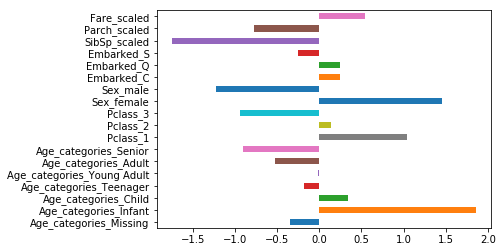

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']



lr=LogisticRegression()
lr.fit(train[columns],train["Survived"])
coefficients=lr.coef_
feature_importance=pd.Series(coefficients[0],index=columns)
feature_importance.plot.barh()



## Training a model using relevant features.

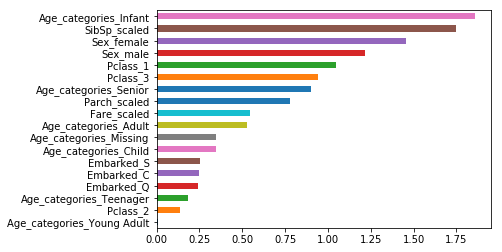

In [13]:
#To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in
#order of size:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()
#We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [14]:
#code snippet:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']
all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)


0.8148019521053229


C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

## Submitting Improved Model to Kaggle - Attempt1.5

In [ ]:
#The cross validation score of 81.48% is marginally higher than the cross validation score for the model we created in
#the previous mission, which had a score of 80.2%.

#Lets see if this translate to unseen data,Let's train a model using the columns from the previous step, make some
#predictions on the holdout data and submit it to Kaggle for scoring.

In [15]:
#code snippet:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_1.csv",index=False)

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Feature Engineering Using Binning

In [10]:
#we'll see that the score is 77.0% It's only a small improvement, but we're moving in the right direction.

#A lot of the gains in accuracy in machine learning come from Feature Engineering. Feature engineering is the practice
#of creating new features from our existing data.

#One common way to engineer a feature is using a technique called binning.Binning is when we take a continuous feature
#like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'),turning it into
#a categorical variable.

#This can be useful when there are patterns in the data that are non-linear and we're using a linear model (like
#logistic regression). We actually used binning in the previous mission when we dealt with the Age column, although we
#didn't use the term.

#Let's look at histograms of the Fare column for passengers who died and survived, and see if there are patterns that
#we can use when creating our bins.

#Looking at the values, it looks like we can separate the feature into four bins to capture some patterns from the data
#0-12
# 12-50
# 50-100
# 100+
#we can use the pandas.cut() function to create our bins.

In [16]:
#code snippet:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

## Engineering Features From Text Columns

In [17]:
#Another way to engineer features is by extracting data from text columns. Name and Cabin columns weren't useful by
#themselves, but what if there is some data there we could extract? Let's take a look at a random sample of rows from
#those two columns:

#we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is
#representative of the type of cabin, which could be useful data for us. We can use the pandas Series.str accessor and
#then subset the first character using brackets:



#Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like
#the 'Countess' from the final row of our table above.By spending some time researching the different titles, we can
#categorize these into six types:

# Mr
# Mrs
# Master
# Miss
# Officer
# Royalty

#We can use the Series.str.extract method and a regular expression to extract the title from each name and then use the
#Series.map() method and a predefined dictionary to simplify the titles.

In [18]:
#code snippet:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] = train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

## Finding Correlated Features

In [19]:
#We now have 34 possible feature columns we can use to train our model. One thing to be aware of as we start to add
#more features is a concept called collinearity. Collinearity occurs where more than one feature contains data that
#are similar.

#The effect of collinearity is that our model will overfit - we may get great results on our test data set, but 
#then the model performs worse on unseen data (like the holdout set).

#One easy way to understand collinearity is with a simple binary variable like the Sex column in our dataset. Every
#passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'.

#As a result, when we created our two dummy columns from the categorical Sex column, we've actually created two columns
#with identical data in them. This will happen whenever we create dummy columns, and is called the dummy variable trap.
#The easy solution is to choose one column to drop any time our make dummy columns.

#A common way to spot collinearity is to plot correlations btw each pair of variables in a heatmap

#The darker squares, whether the darker red or darker blue, indicate pairs of columns that have higher correlation and
#may lead to collinearity. The easiest way to produce this plot is using the DataFrame.corr() method to produce a
#correlation matrix, and then use the Seaborn library's seaborn.heatmap() function to plot the values:

#We've created a function containing that code to make it easier for you to plot the correlations between the features
#in our data.

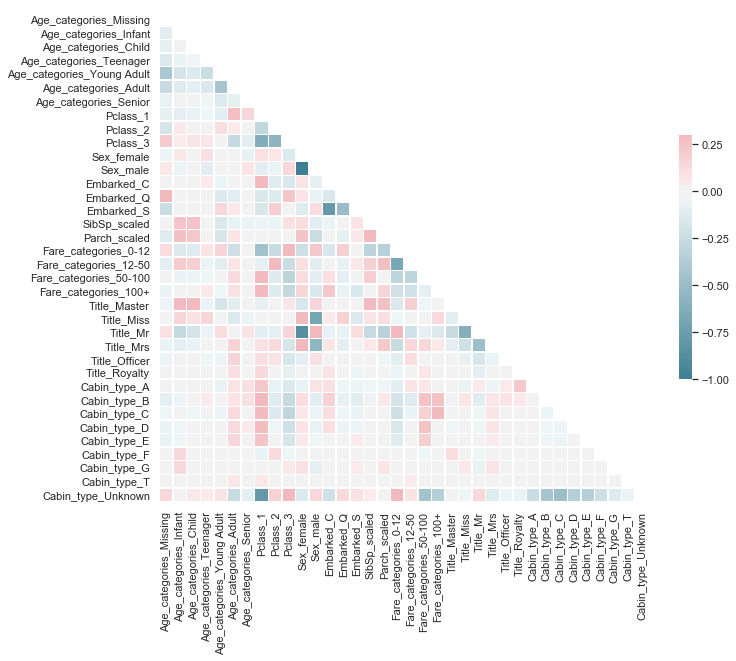

In [20]:
#code snippet:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

## Final Feature Selection using RFECV

In [28]:
#We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will
#remove the columns Sex_female and Sex_male since the title data may be more nuanced.

#Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

# Pclass_2
# Age_categories_Teenager
# Fare_categories_12-50
# Title_Master
# Cabin_type_A

#we manually used the logit coefficients to select the most relevant features. An method is to use one of sklearn's
#inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature
#elimination with cross-validation.

#The RFECV class starts by training a model using all of our features and scores it using cross validation. It then
#uses the logit coefficients to eliminate the least important feature, and trains and scores a new model. At the end,
#the class looks at all the scores, and selects the set of features which scored highest.

#Like the LogisticRegression class, RFECV must first be instantiated and then fit. The first parameter when creating
#the RFECV object must be an estimator, and we need to use the cv parameter to specific the number of folds for cv


# #Once the RFECV object has been fit, we can use the RFECV.support_ attribute to access a boolean mask of True and False
# #values which we can use to generate a list of optimized columns:


In [23]:
#code snippet:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr=LogisticRegression()
selector=RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns=all_X.columns[selector.support_]
optimized_columns

#feature selection-> R

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

## Training A Model Using Optimized Columns

In [24]:
# The RFECV() selector returned only four columns:

# ['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown']
# Let's train a model using cross validation using these columns and check the score.

In [25]:
#CODE Snippet:
all_X = train[optimized_columns]
all_y = train["Survived"]
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.8226549199863807

## Submitting our Model to Kaggle - Attempt2

In [ ]:
#This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model. Let's train
#these columns on the holdout set, save a submission file and see what score we get from Kaggle.

In [26]:
#code snippet:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
